### Download the data

In [1]:
!wget https://raw.githubusercontent.com/suvigyajain0101/CaseStudies/main/AdverseEventClassification/Data/AE_Data.csv

--2022-08-28 21:04:24--  https://raw.githubusercontent.com/suvigyajain0101/CaseStudies/main/AdverseEventClassification/Data/AE_Data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5998096 (5.7M) [text/plain]
Saving to: ‘AE_Data.csv’

AE_Data.csv         100%[===================>]   5.72M  --.-KB/s    in 0.02s   

2022-08-28 21:04:25 (326 MB/s) - ‘AE_Data.csv’ saved [5998096/5998096]



### Setup

In [2]:
! pip install tensorflow-text

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.6 MB 31.7 MB/s 
     |████████████████████████████████| 511.7 MB 6.3 kB/s 
     |████████████████████████████████| 1.6 MB 62.0 MB/s 
     |████████████████████████████████| 438 kB 69.6 MB/s 
     |████████████████████████████████| 5.8 MB 59.1 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
  Attempting uninstall: keras
    Found existing installation: keras 2.8.0
    Uninstalling keras-2.8.0:
      Successfully uninstalled keras-2.8.0
  Attempting uninstall: gast
    Found existing installation: gast 0.5.3
    Unins

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import numpy as np
import re
import os
import shutil

import tensorflow_hub as hub
import tensorflow_text as text
# from official.nlp import optimization  # to create AdamW optimizer

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

In [4]:
df = pd.read_csv('/content/AE_Data.csv')
df.head()

,title,abstract,label
0,antimicrobial impacts of essential oils on foo...,the antimicrobial activity of twelve essential...,0
1,purification and characterization of a cystein...,antimicrobial peptide (amp) crustin is a type ...,0
2,telavancin activity tested against gram-positi...,objectives: to reassess the activity of telava...,0
3,the in vitro antimicrobial activity of cymbopo...,background: it is well known that cymbopogon (...,0
4,screening currency notes for microbial pathoge...,fomites are a well-known source of microbial i...,0


In [5]:
df['label'].value_counts()

0    3851
1     294
Name: label, dtype: int64

In [6]:
df['text'] = df['title'] + ' ' + df['abstract']
df.head()

,title,abstract,label,text
0,antimicrobial impacts of essential oils on foo...,the antimicrobial activity of twelve essential...,0,antimicrobial impacts of essential oils on foo...
1,purification and characterization of a cystein...,antimicrobial peptide (amp) crustin is a type ...,0,purification and characterization of a cystein...
2,telavancin activity tested against gram-positi...,objectives: to reassess the activity of telava...,0,telavancin activity tested against gram-positi...
3,the in vitro antimicrobial activity of cymbopo...,background: it is well known that cymbopogon (...,0,the in vitro antimicrobial activity of cymbopo...
4,screening currency notes for microbial pathoge...,fomites are a well-known source of microbial i...,0,screening currency notes for microbial pathoge...


### Train Val Test Split

Due to imbalanced dataset, we need to follow an innovative approach to split the data. There are ways in [numpy](https://stackoverflow.com/a/38251213/11383333), which can help with train, val, test split (still not present in sklearn), but we need to do the stratified sampling. So use the sklearn's data split 2 times

In [14]:
from sklearn.model_selection import train_test_split

val_split = 0.2
test_split = 0.2

X = df['text'].values
y = df['label'].values

# First split, split original dataset in train-val combination and test
X_comb, X_test, y_comb, y_test = train_test_split(X, y, test_size=test_split, stratify=y)

# Second split, split train-val combination into train and val dataset
X_train, X_val, y_train, y_val = train_test_split(X_comb, y_comb, test_size=val_split, stratify=y_comb)

In [15]:
print('Label Distribution in the training data')
print(np.unique(y_train, return_counts=True))
print('*'*50)
print('Label Distribution in the validation data')
print(np.unique(y_val, return_counts=True))
print('*'*50)
print('Label Distribution in the testing data')
print(np.unique(y_test, return_counts=True))

Label Distribution in the training data
(array([0, 1]), array([2464,  188]))
**************************************************
Label Distribution in the validation data
(array([0, 1]), array([617,  47]))
**************************************************
Label Distribution in the testing data
(array([0, 1]), array([770,  59]))


In [11]:
tfhub_handle_preprocess = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3')
tfhub_handle_encoder = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4',trainable=True)

In [18]:
EPOCHS = 5
BATCH_SIZE = 32


def train_model(num_epochs=EPOCHS, train_batch_size=BATCH_SIZE):
  def build_classifier_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
    return tf.keras.Model(text_input, net)


  classifier_model = build_classifier_model()

  optimizer = keras.optimizers.Adam(learning_rate=0.01)
  loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
  metrics = tf.metrics.BinaryAccuracy()


  classifier_model.compile(optimizer=optimizer,
                          loss=loss,
                          metrics=metrics)


  history = classifier_model.fit(X_train, y_train,
                                epochs=num_epochs,
                                batch_size=train_batch_size,
                                validation_data=(X_val, y_val))
  return classifier_model, history

Epoch 1/5
83/83 [==============================] - 88s 983ms/step - loss: 0.4014 - binary_accuracy: 0.9238 - val_loss: 0.2577 - val_binary_accuracy: 0.9292
Epoch 2/5
83/83 [==============================] - 80s 962ms/step - loss: 0.3081 - binary_accuracy: 0.9291 - val_loss: 0.2569 - val_binary_accuracy: 0.9292
Epoch 3/5
83/83 [==============================] - 79s 952ms/step - loss: 0.3094 - binary_accuracy: 0.9284 - val_loss: 0.3006 - val_binary_accuracy: 0.9292
Epoch 4/5
83/83 [==============================] - 78s 941ms/step - loss: 0.3181 - binary_accuracy: 0.9291 - val_loss: 0.3407 - val_binary_accuracy: 0.9292
Epoch 5/5
83/83 [==============================] - 78s 937ms/step - loss: 0.3160 - binary_accuracy: 0.9291 - val_loss: 0.4129 - val_binary_accuracy: 0.9292


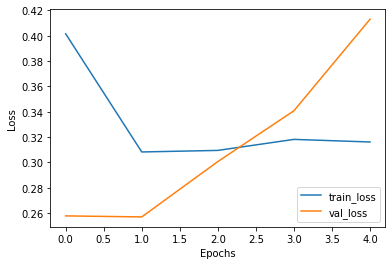

In [19]:
# Plotter function
def plot_history():
    plt.plot(history.history["loss"])
    plt.plot(history.history["val_loss"])
    plt.legend(["train_loss", "val_loss"])
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.show()

plot_history()

In [ ]:
THRESHOLD = -0.4

# Generate predictions
y_probs = classifier_model.predict(X_test)

y_pred = np.where(y_probs > THRESHOLD, 1, 0)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
def parse_confusion_matrix(x):
  '''
  Function parses confusion matrix and 
  returns TP, TN, FP and FN for a binary classification model
  '''
  tn, fp, fn, tp = x.ravel()

  return [tp, tn, fp, fn]

def parse_clf_report(x):
  '''
  Functinon parses classificatin report dictionary
  '''

  f1 = x['weighted avg']['f1-score']
  precision = x['weighted avg']['precision']
  recall = x['weighted avg']['recall']
  positive_f1 = x['1']['f1-score']
  positive_precision = x['1']['precision']
  positive_recall = x['1']['recall']

  return [f1, precision, recall, positive_f1, positive_precision, positive_recall]

def prepare_exp_report(master_list, exp_name, confsn_mat, clf_rpt):
  '''
  Function prepares experiment report, 
  in a nutshell it's just concataneting few lists
  '''
  # x is the forest here
  return master_list.append([exp_name] + confsn_mat + clf_rpt)


  
# Prepare Classification Report
exp_confusion_matrix = confusion_matrix(y_test,y_pred)
exp_clf_report = classification_report(y_test,y_pred, output_dict=True)
print(exp_confusion_matrix)
print('\n')
print(pd.DataFrame(exp_clf_report))


EXPERIMENT_RESULTS = []
exp_name1 = 'BERT'

prepare_exp_report(EXPERIMENT_RESULTS, 
                    exp_name1, 
                    parse_confusion_matrix(exp_confusion_matrix), 
                    parse_clf_report(exp_clf_report))

SCHEMA = ['Experiment Name', 'True Positives', 'True Negatives', 'False Positives', 
          'False Negatives', 'Overall F1 Score','Overall Precision','Overall Recall',
          'F1 for Positives Records','Precision for Positive Records', 'Recall for Positive Records']

pd.DataFrame(EXPERIMENT_RESULTS, columns=SCHEMA)

False Negatives are exactly what the model should not be catching. It's very important in business cases like this to focus on reducing the False Negatives. Overall, we can say that the **model performance is terrible in the context of the business case.**